

## Feature Engineering

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import inv_boxcox

# supress unnecessary warnings for readability and cleaner presentation
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('bmh')

In [2]:
# reading data
df_train = pd.read_csv('use_case_data.csv')
df_score = pd.read_csv('score_data.csv')

df_train['data_type'] = 'train'
df_score['data_type'] = 'score'

In [3]:
# helper function which performs all steps of data processing which we applied during 
# Data cleaning and preprocessing
def prepare_data():
    
    # removing negative market shares
    temp = df_train[df_train['Market_Share'] >= 0]
    
    # applying boxcox
    market_share = stats.boxcox(temp['Market_Share'].values + 1e-30, lmbda=0.25)
    
    # combining train and score
    data = pd.concat([temp.drop(columns='Market_Share'), df_score],ignore_index=True)
    
    # adding response variable
    data['Market_Share'] = np.nan
    mask = data['data_type'] == 'train'
    data.loc[mask, 'Market_Share'] = market_share
    data.drop(columns='data_type', inplace=True)
    
    # changing dtype to category
    data['ITEMSCODE'] = data['ITEMSCODE'].astype('category')

    # spliting to year and month, adding to not_useful_features list
    data['LAUNCH_YEAR'], data['LAUNCH_MONTH'] = data['NPLLAUNCHDATE'].map(str).apply(
        lambda x: [x[:4], x[4:]]).str   
    
    # removing not useful features
    not_useful = ['BRMID', 'LATESTPERIODINDEX', 'NPLLAUNCHDATE', 'ISREPLACEMENT', 'BRM', 'MARKETEDBRAND',
                  'BRANDSUBFAMILY', 'NPLLAUNCHYEAR', 'RTYPE', 'ITEMSHAPE']
    
    data.drop(columns=not_useful, inplace=True)
    
    # filling missing values
    data['SPECIALFLAVOR'].fillna('NOSPECIALFLAVOR', inplace=True)
    data['TIPCOLOR'].fillna('NOTIPCOLOR', inplace=True)
    
    # transform categorical features into the appropriate type
    for c in data.columns:
        col_type = data[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            data[c] = data[c].astype('category')  
    
    print('all data shape: {}'.format(data.shape))
    return data

In [4]:
def aggregate(data, f_1, f_2):
    """Aggregates f_1 by f_2"""
    mean_ = '{}_{}_mean'.format(f_1, f_2)
    median_ = '{}_{}_median'.format(f_1, f_2)
    std_ = '{}_{}_std'.format(f_1, f_2)
    temp = data.groupby(f_1)[f_2].aggregate(
        {mean_: np.mean, std_: np.std, median_: np.median}).reset_index()
    
    for x in (mean_, std_, median_):
        temp[x].fillna(0, inplace=True)
    
    return data.merge(temp)

In [5]:
def get_final_data(data, to_dummy=False, cardinality_ratio=1.):
    data_copy = data.copy()
    
    # removing high cardinality categorical features
    if cardinality_ratio < 1.:
        n = len(data_copy)
        high_cardinalty_features = []
        for c in data_copy.columns:
            if data_copy[c].dtype.name == 'category' and len(data_copy[c].unique()) / n > cardinality_ratio:
                high_cardinalty_features.append(c)
        print('Removing {} features, which have high cardinality.'.format(high_cardinalty_features))
        data_copy.drop(columns=high_cardinalty_features, inplace=True)
    
    # one-hot encoding for categorical features
    if to_dummy:
        data_copy = pd.get_dummies(data_copy)
        
    print('all data shape: {}'.format(data.shape))
    # splitting into train and score
    mask = data_copy['Market_Share'].notnull()    
    training_data, score_data = data_copy[mask], data_copy[np.invert(mask)]
    score_data.drop(columns='Market_Share', inplace=True)
    print('training data shape: {}, score data shape: {}'.format(training_data.shape, score_data.shape))
    return training_data, score_data


In [6]:
df = prepare_data()

# split into numeric and categorical
numeric_fs = [c for c in df.columns if df[c].dtype.name != 'category' and c != 'Market_Share']
categoircal_fs = list(set(df.columns) - set(numeric_fs) - {'Market_Share'})

all data shape: (1721, 32)


In [7]:
to_be_aggregated = (
    'TCLASS', 'BLDIMAGE', 'PCKT', 'LOCALCLASS', 'INTERNATIONALINDICATOR', 'ISSTRATEGIC', 'REGION', 'THICATEGORY',
    'PRICECLASSON','PRICECLASS', 'LENCATEGORY', 'CHARINDICATOR', 'INDICATOR', 'TRACKINGSTATUS')
for f_1 in to_be_aggregated:
    for f_2 in numeric_fs:
        df = aggregate(df, f_1, f_2)

print('all data shape: {}'.format(df.shape))

all data shape: (1721, 200)




## Modeling

**Import librairies**

In [8]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from helpers import evaluate_train_test

In [9]:
# preparing data
training_df, score_df = get_final_data(df, to_dummy=True, cardinality_ratio=0.5)

numeric_fs = [c for c in df.columns if df[c].dtype.name != 'category' and c != 'Market_Share']
categoircal_fs = list(set(df.columns) - set(numeric_fs) - {'Market_Share'})

Removing ['BRANDONMARKET'] features, which have high cardinality.
all data shape: (1721, 200)
training data shape: (1692, 1371), score data shape: (29, 1370)


**Train - Test split**

In [10]:
# we will keep 15% of data for final testing
assert len(training_df) == len(df_train[df_train['Market_Share'] >= 0])

train, test = train_test_split(training_df, test_size=0.15, shuffle=True)
print(train.shape, test.shape)

(1438, 1371) (254, 1371)


In [11]:
y_train, X_train = train['Market_Share'], train.drop(columns='Market_Share')
y_test, X_test = test['Market_Share'], test.drop(columns='Market_Share')

In [12]:
assert len(y_train) == len(X_train)
assert len(y_test) == len(X_test)

**5 fold CV strategy**

We use the **cross_val_score** function of Sklearn.

In [13]:
# CV function
n_folds = 5
def rmsle_cv(model, n_folds=n_folds, fit_params=None):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, 
                                    scoring="neg_mean_squared_error", 
                                    cv=kf, fit_params=fit_params))
    return rmse

**Base models and their scores:**

In [ ]:
# X_train, X_test = X_train[numeric_fs], X_test[numeric_fs]

* **LASSO Regression :**

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's **Robustscaler()** method on pipeline.

In [ ]:
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0003, random_state=1))
score = rmsle_cv(model_lasso, n_folds=5)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

* **Elastic Net Regression :**

again made robust to outliers

In [ ]:
model_enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.8, random_state=3))
score = rmsle_cv(model_enet, n_folds=5)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

* **XGBoost :**

In [ ]:
model_xgb = xgb.XGBRegressor(
    objective='reg:linear',
    n_estimators=5000,
    learning_rate=0.01,

    max_depth=3,              # Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
    max_leaf_nodes=8,         # The maximum number of terminal nodes or leaves in a tree.
    min_child_weight=1.2,     # Minimum sum of instance weight (hessian) needed in a child. 
                              # Too high values can lead to under-fitting hence, it should be tuned using CV.
   
    subsample=0.5213,         # Denotes the fraction of observations to be randomly samples for each tree.
    colsample_bytree=0.4603,  # Denotes the fraction of columns to be randomly samples for each tree.

    gamma=0.022,              # Gamma specifies the minimum loss reduction required to make a split.
    reg_alpha=0.4640,         # L1 regularization term on weight
    reg_lambda=0.8571,        # L2 regularization term on weights 
    
    silent=1,
    random_state=7,
    num_jobs=4
)

score = rmsle_cv(model_xgb, n_folds=5)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

* **LightGBM :**

In [22]:
model_lgb = lgb.LGBMRegressor(
    boosting_type='gbdt',
    
    objective='regression',
    n_estimators=5000,
    learning_rate=0.03,
    
    max_depth=6,             # Specify the max depth to which tree will grow. 
#     num_leaves=31,             # Number of leaves in one tree

    min_child_weight=11,     # minimal sum hessian in one leaf
    min_data_in_leaf=5,       # Min number of data in one leaf.
    
    subsample=0.8,            # Specifies the fraction of data to be used for each iteration
    subsample_freq=5,
    bagging_seed=9,
    
#     colsample_bytree=0.5,  # Specifies the fraction of features to be taken for each iteration
    feature_fraction_seed=7,
    
#     min_gain_to_split=0.05,    # Min gain to perform splitting
    reg_alpha=0.,
    reg_lambda=0.,
    **best
)

score = rmsle_cv(model_lgb, n_folds=5, fit_params={})
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.2537 (0.0090)




*****EVALUATION METRICS*****
Model: LGBMRegressor
DataType: Train
RMSE: 0.043



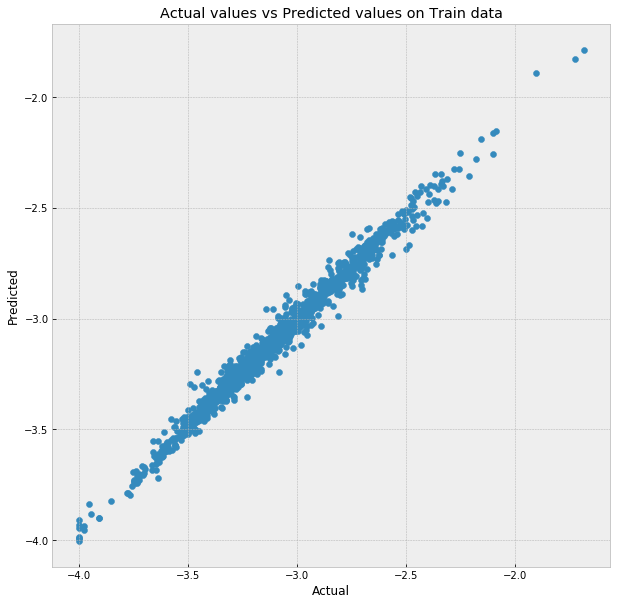


**ClassficationMetrics**
ROC AUC:        0.951
Accuracy:       0.974 (Overall, how often is the classifier correct?)
MissClass rate: 0.026 (Overall, how often is it wrong?)
Recall:         0.912 (When it is actually Y, how often does it predict Y?)
FalseP rate:    0.010 (When it is actually N, how often does it predict N?)
Precision:      0.956 (When it predicts Y, how often is it correct?)
F Score:        0.933 (The weighted average of recall and precision.)



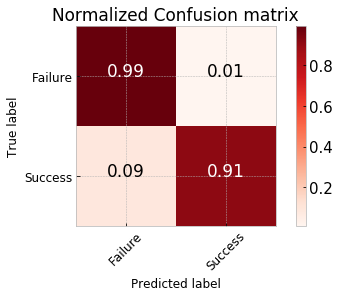


*****EVALUATION METRICS*****
Model: LGBMRegressor
DataType: Test
RMSE: 0.252



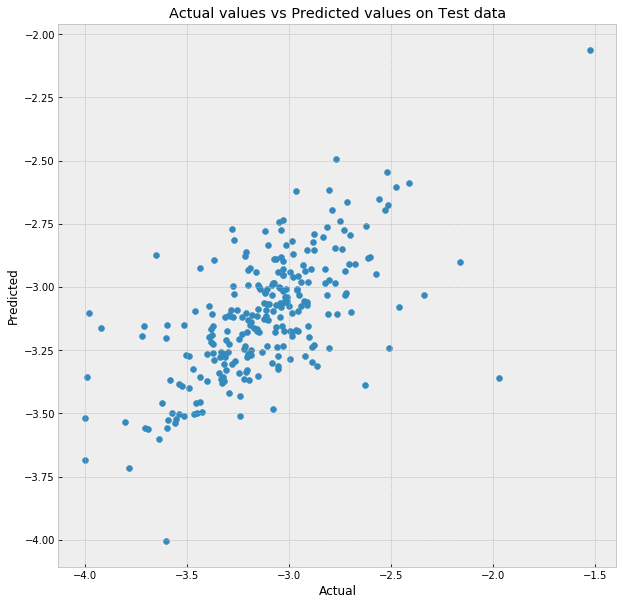


**ClassficationMetrics**
ROC AUC:        0.674
Accuracy:       0.854 (Overall, how often is the classifier correct?)
MissClass rate: 0.146 (Overall, how often is it wrong?)
Recall:         0.405 (When it is actually Y, how often does it predict Y?)
FalseP rate:    0.057 (When it is actually N, how often does it predict N?)
Precision:      0.586 (When it predicts Y, how often is it correct?)
F Score:        0.479 (The weighted average of recall and precision.)



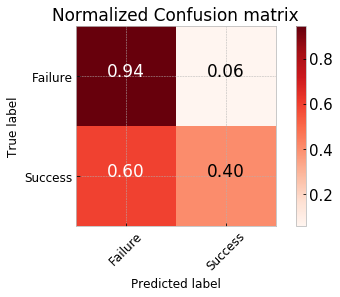

In [23]:
evaluate_train_test(model_lgb, X_train, y_train, X_test, y_test)

In [ ]:
models = [model_lasso, model_enet, model_xgb, model_lgb]

In [ ]:
for model in models:
    evaluate_train_test(model, X_train, y_train, X_test, y_test)
    print()

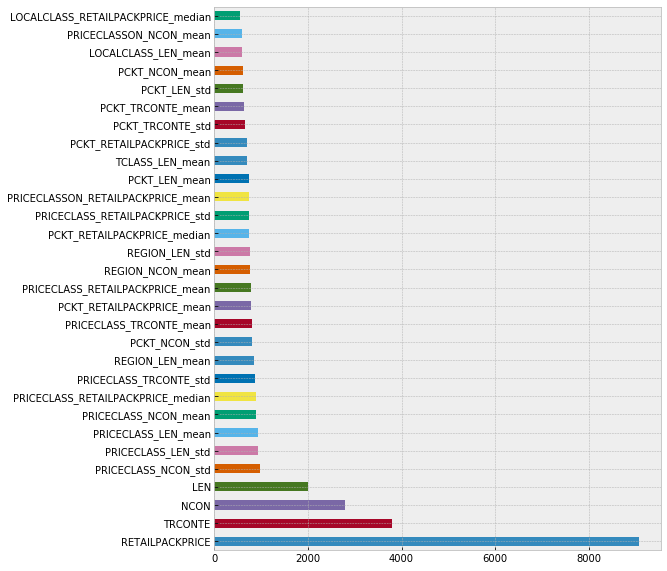

In [24]:
feat_imp = pd.Series(model_lgb.feature_importances_, index=X_train.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [ ]:
feat_imp = pd.Series(model_xgb.feature_importances_, index=X_train.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10));

In [17]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [18]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_split_gain': '{:.3f}'.format(params['min_split_gain'])
        
    }

    regressor = lgb.LGBMRegressor(
        boosting_type='gbdt',
        objective='regression',
        n_estimators=5000,
        learning_rate=0.03,
        max_depth=-1,
        min_child_weight=11,
        min_data_in_leaf=5,  
        subsample=0.8,            
        subsample_freq=5,
        bagging_seed=9,
        feature_fraction_seed=7,
        **params
    )

    score = rmsle_cv(regressor, n_folds=5)
    print(params, '{:.3f}'.format(score.mean()), '{:.3f}'.format(score.var()))
    return score.mean()


space = {
    'num_leaves': hp.quniform('num_leaves', 32, 128, 4),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.8),
    'min_split_gain': hp.uniform('min_split_gain', 0.0, 0.1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30)

{'num_leaves': 72, 'colsample_bytree': '0.652', 'min_split_gain': '0.016'} 0.254 0.000
{'num_leaves': 64, 'colsample_bytree': '0.737', 'min_split_gain': '0.061'} 0.259 0.000
{'num_leaves': 76, 'colsample_bytree': '0.370', 'min_split_gain': '0.017'} 0.251 0.000
{'num_leaves': 48, 'colsample_bytree': '0.616', 'min_split_gain': '0.078'} 0.260 0.000
{'num_leaves': 60, 'colsample_bytree': '0.366', 'min_split_gain': '0.022'} 0.251 0.000
{'num_leaves': 72, 'colsample_bytree': '0.412', 'min_split_gain': '0.013'} 0.252 0.000
{'num_leaves': 40, 'colsample_bytree': '0.473', 'min_split_gain': '0.057'} 0.257 0.000
{'num_leaves': 108, 'colsample_bytree': '0.323', 'min_split_gain': '0.000'} 0.248 0.000
{'num_leaves': 92, 'colsample_bytree': '0.761', 'min_split_gain': '0.006'} 0.251 0.000
{'num_leaves': 100, 'colsample_bytree': '0.745', 'min_split_gain': '0.078'} 0.260 0.000
{'num_leaves': 108, 'colsample_bytree': '0.756', 'min_split_gain': '0.031'} 0.255 0.000
{'num_leaves': 112, 'colsample_bytree': 

In [19]:
best

{'colsample_bytree': 0.3010643615474637,
 'min_split_gain': 0.0003118062357423865,
 'num_leaves': 128.0}

In [21]:
best['num_leaves'] = 128